# AI-Driven Detection of Deepfake Phishing Attacks

3/24/2025, Dave Sisk, https://github.com/davidcsisk, https://www.linkedin.com/in/davesisk-doctordatabase/

This notebook pulls together AI-based transcription, unsupervised anomaly detection, vector search against known exploits, and a knowledge graph for named entity recognition. The purpose is to provide an example of detecting possible phishing attempts delivered as binary audio or video content. 

A number of AI-driven multi-model deepfake exploits have garnered much attention over the past year, including deepfaked audio/video phishing email of the company's CEO instructing employees to make a funds transfer, and even a CEO himself being deepfaked into transferring company funds to a fake corporate headquarters.  Let's examine how we can pull together tools and processes from the AI/ML/data science realm to detect this type of deepfake attack. 

By "multi-modal", I'm referring to attacks delivered as communications that might include text, image, audio, and/or video content. 

Why examine this particular case?  Here's why: Based on results from a 2024 poll conducted by Deloitte, **24.9% of 2190 C-suite and executives say that their organization has experienced one or more deepfake attacks on financial and accounting targets**.  Roughly 1 out of every 4 organizations is seeing this flavor of attack.

## Examples of real-world attacks from 2024 - present

Deepfaked CEO scam attempt: https://www.theguardian.com/technology/article/2024/may/10/ceo-wpp-deepfake-scam

Private video sharing phishing attack: https://incidentdatabase.ai/cite/965#r4845

Deepfaked Brad Pitt and the $850K romance scam:  https://incidentdatabase.ai/cite/901/

#### Proposed AI-driven Attack Detection Framework:
![Deepfake-Detection-Framework.jpg](.\Deepfake-Detection-Framework.jpg)

"Easy for you to draw"...right?  Let's demonstrate these processes in action, in the most platform-independent way that is feasible.

In [ ]:
#! pip install vosk
# Vosk models download and unzip:  https://alphacephei.com/vosk/models
#! pip install spacy
# Install the spaCy model
#! python -m spacy download en_core_web_sm
# Ensure ipywidgets is installed to avoid TqdmWarning
#!pip install ipywidgets

### List of Files Used in This Notebook

- `./Deepfake-Detection-Framework.jpg`: Flowchart image for the framework
- `./corporate_communication_examples.csv`: CSV file containing corporate communication examples
- `./deepfake_phishing_examples.csv`: CSV file containing known phishing examples
- `./deepfake-example_DT-transfer-request-audio-01.wav`: Audio file for transcription
- `./deepfake=example_EM-SocialSecurityPhishing-video-01.mp4`: Video file for transcription


## Fabricated Example Deepfake Attacks For Analysis:
The fabricated artifacts below were designed to appear realistic and relevant to our organization.

**If an audio message with this very recognizable voice like the one below came in what appeared to be an official communication, how believable would it be?**

In [58]:
# Play the audio using the default OS audio player
wav_file = './deepfake-example_DT-transfer-request-audio-01.wav'
!start {wav_file}

**If a video message from this very well-known public figure similar to the one below was sent to all employees from what appeared to be an official source, how believable would it be?**

In [59]:
# Play the video using the default OS video player
video_file = './deepfake-example_EM-SocialSecurityPhishing-video-01.mp4'
!start {video_file}

For the record, I used inexpensive and readily-available AI tech to create both of these deepfakes.  If these examples are not believable enough, consider that it's merely a matter of using slightly more expensive or involved AI tech to create even better deepfakes.  Overall, the obvious answer to the question at hand is this:  These are believable enough to potentially cause harm.

## Pre-req: Build Vectorized Library of known phishing attacks
In the proposed framework, this datastore of known attacks would be built over time by the reinforcement learning loop.  However, for this exercise, we'll explicity build one in a temporary datastore using previously AI-generated phishing examples as the base data.

Note that I'm using a free/open-source HuggingFace text embedding LLM for this purpose. This model runs locally, and there are no external API calls...no data leaves the host or device this notebook is running on.

In [79]:
# Build the datastore of known phishing messages (30 samples)

# Explicitly import tqdm to avoid TqdmExperimentalWarning
import sys
from tqdm import tqdm, trange

# Patch sentence_transformers to use tqdm instead of tqdm.autonotebook
import sentence_transformers.cross_encoder.CrossEncoder as ce
ce.tqdm = tqdm
ce.trange = trange

import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import warnings

# Suppress the FutureWarning from transformers
warnings.filterwarnings('ignore', category=FutureWarning, module='transformers.tokenization_utils_base')

# Load the CSV into a pandas dataframe
exploit_df = pd.read_csv('./deepfake_phishing_examples.csv')

# Ensure 'Subject' and 'Body' columns exist, create them if missing
if 'Subject' not in exploit_df.columns:
    exploit_df['Subject'] = ''
if 'Body' not in exploit_df.columns:
    exploit_df['Body'] = ''

# Initialize the sentence-transformers model
embedding_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Combine Subject and Body into a single column for embedding, handling empty values
exploit_df['Subject'] = exploit_df['Subject'].fillna('')
exploit_df['Body'] = exploit_df['Body'].fillna('')
exploit_df['combined_text'] = (exploit_df['Subject'] + ' ' + exploit_df['Body']).str.strip()

# Calculate embeddings for the combined text
exploit_df['embeddings'] = exploit_df['combined_text'].apply(lambda x: embedding_model.encode(x))

# Function to perform cosine similarity search
def search_similar(query, top_n=3):
    query_embedding = embedding_model.encode(query).reshape(1, -1)
    embeddings = np.vstack(exploit_df['embeddings'].values)
    similarities = cosine_similarity(query_embedding, embeddings).flatten()
    top_indices = similarities.argsort()[-top_n:][::-1]
    results = exploit_df.iloc[top_indices][['Subject', 'Body', 'combined_text']].copy()
    results['similarity_score'] = similarities[top_indices]
    results['preview'] = results['combined_text'].apply(lambda x: x[:100] if x else 'No content available')
    return results[['preview', 'similarity_score']]

exploit_df.shape

(34, 4)

In [80]:
# Take a look at a few rows
exploit_df.sample(3)

,Subject,Body,combined_text,embeddings
28,Crisis Management Transfer,"Move $77,300 now. This action is related to co...","Crisis Management Transfer Move $77,300 now. T...","[0.018753365, -0.024684794, -0.04443557, -0.01..."
25,Fund Allocation: Do Not Delay,"Initiate wire of $91,200 to fund the restructu...",Fund Allocation: Do Not Delay Initiate wire of...,"[-0.0010739114, 0.012882677, -0.05824802, 0.05..."
2,Secure Transfer – Do Not Share,This is highly confidential. I need you to tra...,Secure Transfer – Do Not Share This is highly ...,"[0.007950112, 0.030819487, -0.005739676, -0.03..."


Note that the purpose of the vector embeddings is **to capture the *meaning* of the text in a numeric form that we can do *downstream analytics* with**.  These are the <u>**meaningful numbers**</u> you hear me talk about.

In [81]:
# First row - full combined_text and a summarized vector embedding
import textwrap
first_row = exploit_df.iloc[0]
wrapped_text = textwrap.fill(first_row['combined_text'], width=60)
embedding_sample = [float(x) for x in first_row['embeddings'][:2]] + ['...'] + [float(x) for x in first_row['embeddings'][-1:]]
print("Combined Text:\n", wrapped_text)
print("\nVector Embedding:\n", embedding_sample)
len(exploit_df['embeddings'][0])  # Length of the embedding vector

Combined Text:
 Urgent Wire Transfer – Confidential Hi [Employee Name], I’m
in a meeting right now and need you to initiate a wire
transfer of $52,400 to a vendor we’re onboarding. Use the
account I’ve attached. This is time-sensitive. I’ll explain
later. Please confirm once it’s done. —[Impersonated CEO
Name]

Vector Embedding:
 [-0.11886531114578247, 0.0924694836139679, '...', -0.08786123245954514]


384

Unlike a traditional one-hot encoding which would produce a very large intractable sparse matrix, this vector embedding is a dense matrix with (in this case) 384 features that capture what that piece of text means.  Since you can calculate Euclidean distances, Cosine similarities, Dot-Product distances, etc., getting this set of **meaningful numbers** that describe that text passage gives us a tractable means to do similarity comparison/scoring, clustering, anomaly detection, and similar analytical processes with those numbers.

In [82]:
# Example vector search query with a custom number of top matches
query = "urgent action required for account security"
top_n = 5  # Specify the number of top matches to return
results = search_similar(query, top_n=top_n)
print(results)

                                              preview  similarity_score
3   Urgent from Mobile I’m traveling and can’t acc...          0.497088
7   Immediate Compliance Wire I’ve been told we ha...          0.489520
22  Banking Delay Mitigation I’ve been notified th...          0.480011
13  Transfer Instruction: Urgent Initiate a transf...          0.461940
0   Urgent Wire Transfer – Confidential Hi [Employ...          0.421657


Looks good!  In practice, we would build this library over time via the reinforcement learning loop at the bottom right in the framework flowchart.  This means that we would start with little or no examples, and accumulate them as we proceeded, eventually amassing a large library of labeled data as examples. 

Also in practice, these vector search queries would be run against a vector database hydrated with the above-mentioned data instead of against a temporary in-memory dataframe.

## Pre-req:  Construct Knowledge Graph from Available Data

We'll build the core knowledge graph from known good data...for this example, we'll use the AI-generated corporate_communication_examples sample data.

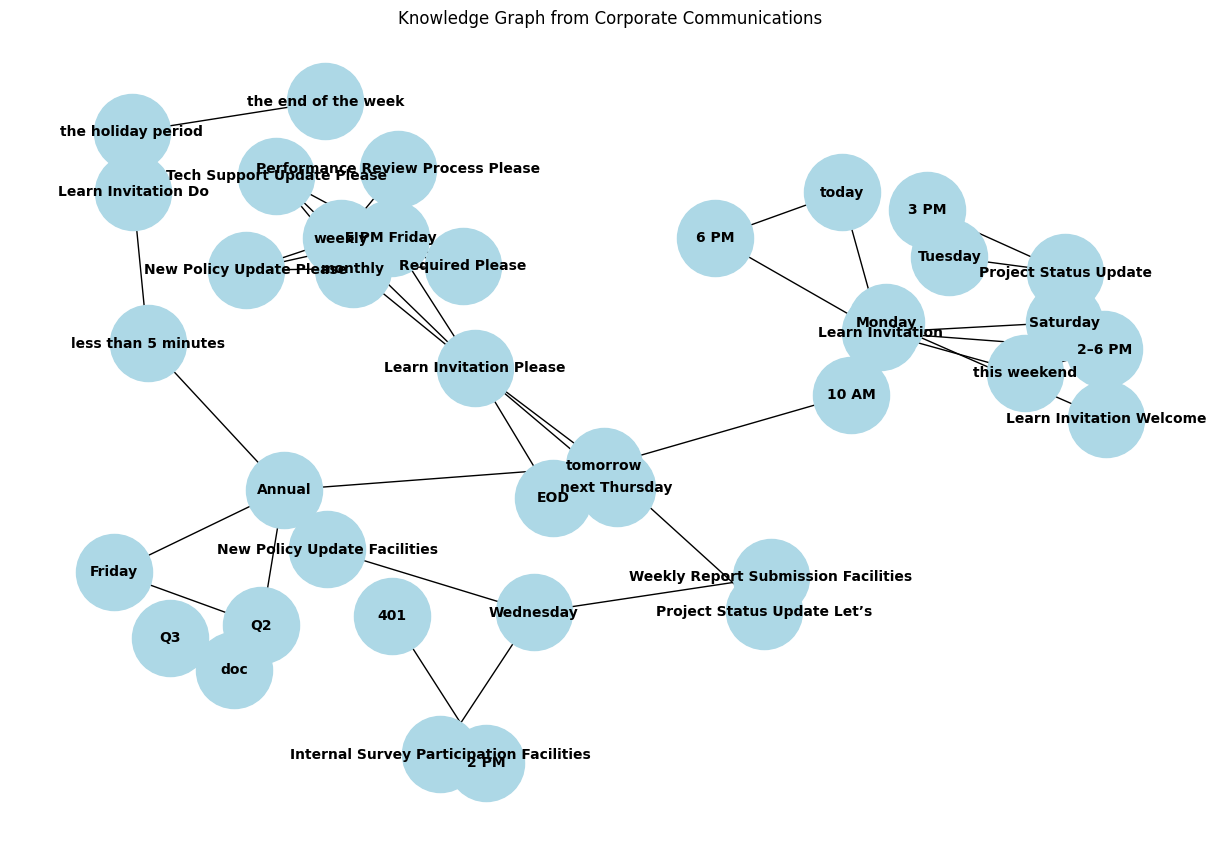

Knowledge Graph contains 39 nodes and 54 edges.


In [83]:
# Build core knowledge graph from known good data
import pandas as pd
import spacy
import networkx as nx
import matplotlib.pyplot as plt

# Load the SpaCy model for NER
nlp = spacy.load("en_core_web_sm")

# Load the corporate communication examples CSV file
corporate_df = pd.read_csv('./corporate_communication_examples.csv')

# Initialize a graph
knowledge_graph = nx.Graph()

# Function to extract entities and relationships from text
def extract_entities_and_relationships(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    # Add edges between entities to represent relationships
    for i, entity1 in enumerate(entities):
        for entity2 in entities[i + 1:]:
            knowledge_graph.add_edge(entity1, entity2)

# Process each row in the dataframe
for _, row in corporate_df.iterrows():
    combined_text = f"{row['Subject']} {row['Body']}"
    extract_entities_and_relationships(combined_text)

# Visualize the knowledge graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph, k=0.5)
nx.draw(knowledge_graph, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=10, font_weight="bold")
plt.title("Knowledge Graph from Corporate Communications")
plt.show()

# Query the count of nodes and edges in the knowledge graph
node_count = knowledge_graph.number_of_nodes()
edge_count = knowledge_graph.number_of_edges()
print(f"Knowledge Graph contains {node_count} nodes and {edge_count} edges.")

We'll extend the knowledge graph with data for the known phishing attempts...this is the same data that we used to hydrate the vector datastore.

In [84]:
# Helper functions for the Knowledge Graph

# Define the extract_entities helper function for subsequent KG use
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents]

# Function to update knowledge graph with new data
def extend_knowledge_graph_with_phishing_data(df, graph):
    for _, row in df.iterrows():
        combined_text = row['combined_text']
        entities = extract_entities(combined_text)
        for i, entity1 in enumerate(entities):
            for entity2 in entities[i + 1:]:
                graph.add_edge(entity1, entity2)

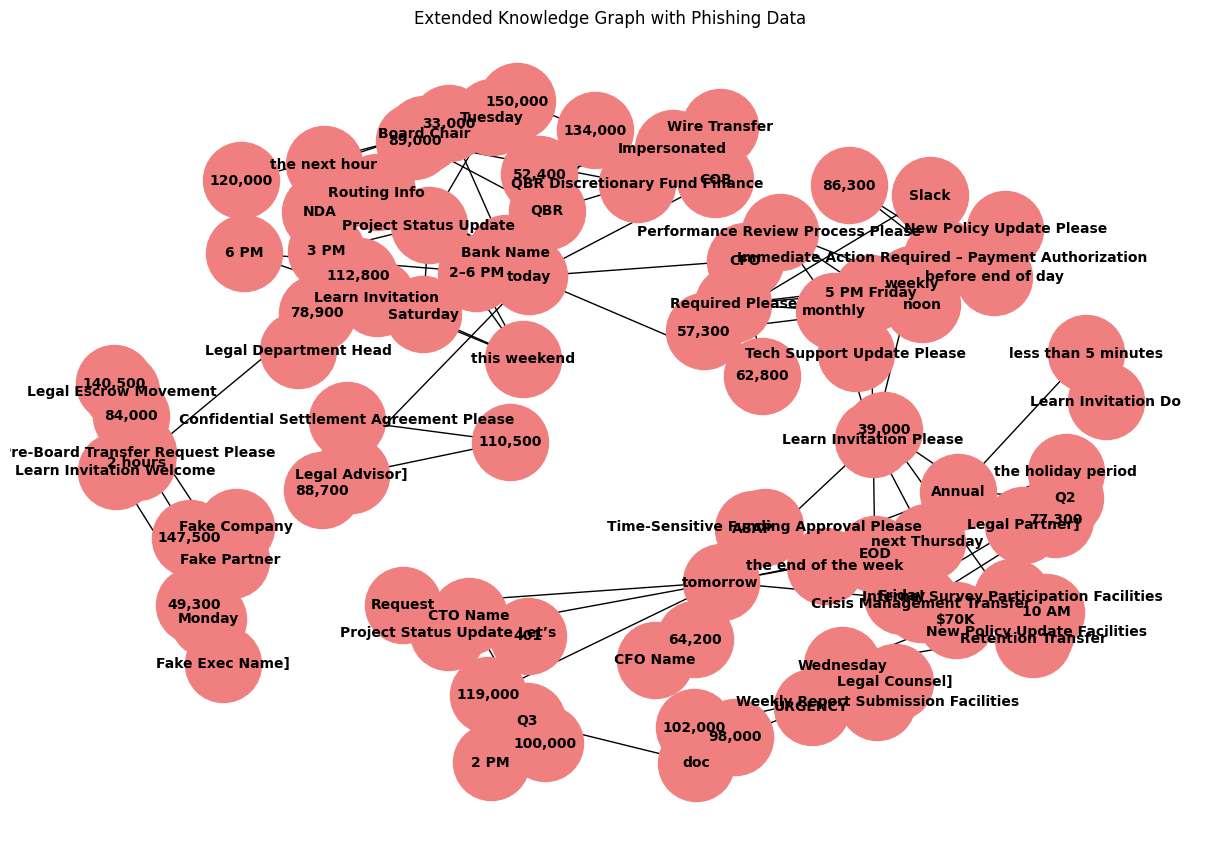

Knowledge Graph contains 98 nodes and 110 edges.


In [85]:
# Extend the knowledge graph with known phishing attempt data
extend_knowledge_graph_with_phishing_data(exploit_df, knowledge_graph)

# Visualize the extended knowledge graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph, k=0.5)
nx.draw(knowledge_graph, pos, with_labels=True, node_size=3000, node_color="lightcoral", font_size=10, font_weight="bold")
plt.title("Extended Knowledge Graph with Phishing Data")
plt.show()

# Query the count of nodes and edges in the knowledge graph
node_count = knowledge_graph.number_of_nodes()
edge_count = knowledge_graph.number_of_edges()
print(f"Knowledge Graph contains {node_count} nodes and {edge_count} edges.")

Looks like what we'd probably expect.  In practice, we would use an enterprise-grade graph database to handle these tasks, rather than a temporary memory structure.  The current approach will suffice for demo purposes, however.

We've built the necessary data artifacts to leverage in this detection framework.  Now, let's proceed to simulate incoming data...

## Incoming Data Enters the Framework

### Pre-processing steps

Our first order of business is to get text transcriptions of the messages in these examples, so we can keep any vector search functionality in the text-only realm where we have known good models for that functionality that are also free, open-source, and locally running. We'll leverage AI tooling to accomplish these transcriptions.

### Deepfake Audio Message
We can transcribe from the WAV audio file directly using the smallest open-source Vosk model that has an internalized language graph...this should produce a reasonably accurate transcription. (If the audio were in compressed MP3 file format [very likely if it came in an email, for instance], we'd have to convert it to WAV audio format first, then transcrible the text from that. That's merely a requirement of this particular model though, not the overall technology.)

We will use the Vosk models for transcription...these are small in size, free/open-source, and run locally, meaning no data leaves the current host in API calls.

In [86]:
# Let's start with the audio transcription
from vosk import Model, KaldiRecognizer
import wave
import json
import textwrap

# Load the 2nd smallest Vosk model
transcription_model = Model("./vosk-model-en-us-0.22-lgraph")

wav_file = './deepfake-example_DT-transfer-request-audio-01.wav'

# Open the audio file
with wave.open(wav_file, "rb") as wf:
    if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getframerate() not in [8000, 16000]:
        raise ValueError("Audio file must be WAV format mono PCM.")
    
    recognizer = KaldiRecognizer(transcription_model, wf.getframerate())
    recognizer.SetWords(True)
    
    transcription = []
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if recognizer.AcceptWaveform(data):
            result = json.loads(recognizer.Result())
            transcription.append(result.get("text", ""))
    
    # Get the final transcription
    final_result = json.loads(recognizer.FinalResult())
    transcription.append(final_result.get("text", ""))

# Combine all parts of the transcription
transcribed_audio_text = " ".join(transcription)

# Wrap the text for better readability
wrapped_audio_text = textwrap.fill(transcribed_audio_text, width=60)
print("Transcribed Audio Text:\n", wrapped_audio_text)

Transcribed Audio Text:
 good morning i'm following up on the audit readiness review
issue in q one expenses for contractor payments we need to
transfer one hundred thirty seven thousand eight hundred and
twenty dollars zero sense to the holding account a b c one
twenty three by three pm today so d oh gee he can reflected
in the pre audit submission let me know once the transfer is
done thanks


### Deepfake Video Message
Next, we'll transcribe text from the audio track on the video to get the exploit message.  This requires multiple steps to get the audio track from the video, then transcribe text from the audio. Extracting audio from the video is easy and deterministic...typical tooling can be used for that task.  AI tech is again needed to transcribe the audio to text...we'll use the same Vosk models for the text transcription. 

In [87]:
# Let's transcribe text from the video
import os
import wave
from vosk import Model, KaldiRecognizer
import json
import textwrap

# Load the Vosk model
model = Model("./vosk-model-en-us-0.22-lgraph")

# Path to the video file
video_file = './deepfake-example_EM-SocialSecurityPhishing-video-01.mp4'
audio_file = './extracted_audio.wav'

# Delete the extracted audio file if it already exists
if os.path.exists(audio_file):
    os.remove(audio_file)

# Extract audio using ffmpeg (suppress output)
!ffmpeg -i {video_file} -vn -acodec pcm_s16le -ar 16000 -ac 1 {audio_file} >nul 2>&1

# Transcribe the extracted audio
with wave.open(audio_file, "rb") as wf:
    if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getframerate() not in [8000, 16000]:
        raise ValueError("Audio file must be WAV format mono PCM.")
    
    recognizer = KaldiRecognizer(model, wf.getframerate())
    recognizer.SetWords(True)
    
    transcription = []
    while True:
        data = wf.readframes(4000)
        if len(data) == 0:
            break
        if recognizer.AcceptWaveform(data):
            result = json.loads(recognizer.Result())
            transcription.append(result.get("text", ""))
    
    # Get the final transcription
    final_result = json.loads(recognizer.FinalResult())
    transcription.append(final_result.get("text", ""))

# Combine all parts of the transcription
transcribed_video_text = " ".join(transcription)

# Wrap the text for better readability
wrapped_video_text = textwrap.fill(transcribed_video_text, width=60)
print("\nTranscribed Video Text:\n", wrapped_video_text)


Transcribed Video Text:
 greetings valued employees immediate action is needed from
you please go to the listed u r l logging into your social
security account and change your password this will provide
a immediate flag that your social security account is valid
please complete this task task by five pm today thank you


## Take these examples combined with typical non-attack communications, and run them through the proposed framework.

We'll use the  AI-generated examples of typical corporate communications, and combine those with the two transcripted deepfake messages, and feed this through the whole process outlined in the framework flowchart.  There are many ways to do this...but this approach gives us a notebook that can be run on a laptop by mere mortals.

In [88]:
import pandas as pd

# Load the CSV file into a pandas dataframe
incoming_df = pd.read_csv('./corporate_communication_examples.csv')

# Add the transcribed audio and video text of the two phishing attempts as new rows
incoming_df = pd.concat([
    incoming_df,
    pd.DataFrame({'Subject': [''], 'Body': [transcribed_audio_text]}),
    pd.DataFrame({'Subject': [''], 'Body': [transcribed_video_text]})
], ignore_index=True)

len(incoming_df)

102

In [89]:
# Display the a few rows of the dataframe to verify the data
incoming_df.sample(3)

,Subject,Body
0,Team Building Activity,We’ll meet in Room 401 for the planning sessio...
59,Tech Support Update,Please submit your weekly reports by 5 PM Frid...
8,New Policy Update,Don’t forget to complete the internal engageme...


In [90]:
# Display the last 3 rows to insure we have the two phishing messages
incoming_df.tail(3)

,Subject,Body
99,Internal Survey Participation,Please confirm your attendance for next Thursd...
100,,good morning i'm following up on the audit rea...
101,,greetings valued employees immediate action is...


Let's calculate their vector embeddings using the same embedding model as was used for the known exploits.

In [91]:
# Combine Subject and Body into a single column for embedding
incoming_df['combined_text'] = (incoming_df['Subject'] + ' ' + incoming_df['Body']).str.strip()

# Calculate embeddings for the combined text
incoming_df['embeddings'] = incoming_df['combined_text'].apply(lambda x: embedding_model.encode(x))

In [23]:
# Take a look at the data
incoming_df.tail(5)

,Subject,Body,combined_text,embeddings
97,Lunch and Learn Invitation,This is a friendly reminder to submit your tim...,Lunch and Learn Invitation This is a friendly ...,"[-0.040350206, 0.009667494, 0.07144351, 0.0270..."
98,Quarterly Goals Alignment,Let me know if there are any blockers on your ...,Quarterly Goals Alignment Let me know if there...,"[-0.073084936, -0.001465058, -0.05476325, -0.0..."
99,Internal Survey Participation,Please confirm your attendance for next Thursd...,Internal Survey Participation Please confirm y...,"[-0.027608344, -0.015846385, 0.069024816, -0.0..."
100,,good morning i'm following up on the audit rea...,good morning i'm following up on the audit rea...,"[-0.0068190717, 0.037922084, -0.036434215, -0...."
101,,greetings valued employees immediate action is...,greetings valued employees immediate action is...,"[-0.065204225, 0.06724257, -0.049596276, -0.06..."


We've done the "enrichment" section of the flowchart, now let's do the "unsupervised ML" section of it. We'll run the vector embeddings of the combined_text through an anomaly detection algorithm. 

Note that the data for this step is time-bounded...we are using a sliding window time-slice.  In practice, we would take a larger time-slice of incoming data for this step, but here we'll use the 102 incoming messages, two of which we know to be phishing attempts.

#### <u><b>Anomaly Detection</b></u> using the <b>vector embeddings</b> as input to one of three approaches: 
- Isolation Forest model
- DBSCAN clustering model
- Adversarial Autoencoder model

You can run all three in different passes to compare the results, but you only need to run 1 cell (choose which one you want) to get a result to work with. 

In this step, we want to cast a fairly large net so we are assured of getting the deepfake phishing attempts, even if it means getting a larger number of false positives (we'll handle those later).

In [98]:
# NOTE:  This is one of three cells to do the intial anomaly detection...run one of the three.
# Most of the comments reflect this algorithm...there might be slight difference with the other two.

# Train unsupervised anomaly detection model using Isolation Forest
from sklearn.ensemble import IsolationForest

# Extract embeddings from the dataframe
embeddings = np.vstack(incoming_df['embeddings'].values)

# Cast a wide net with the contanimation parameter
contamination = 0.1

# Create the Isolation Forest model with automatic contamination
anomaly_detection_model = IsolationForest(n_estimators=100, contamination=contamination, random_state=96)

# Fit the model to the embeddings
anomaly_detection_model.fit(embeddings)

# Predict anomalies (-1 for anomaly, 1 for normal)
incoming_df['anomaly_flag'] = anomaly_detection_model.predict(embeddings)

# Convert anomaly_flag to a more readable format (e.g., 1 for anomaly, 0 for normal)
incoming_df['anomaly_flag'] = incoming_df['anomaly_flag'].apply(lambda x: 1 if x == -1 else 0)


In [74]:
# NOTE:  This is one of three cells to do the intial anomaly detection...run one of the three.

# Train unsupervised anomaly detection model using DBSCAN
from sklearn.cluster import DBSCAN
import numpy as np

# Extract embeddings from the dataframe
embeddings = np.vstack(incoming_df['embeddings'].values)

# We want to cast a wide net
eps=0.5 # 0.5 is the default value for DBSCAN 
min_samples=10 # 5 is the default value for DBSCAN

# Perform DBSCAN clustering
dbscan_model = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
dbscan_labels = dbscan_model.fit_predict(embeddings)

# Add the DBSCAN labels to the dataframe
incoming_df['dbscan_label'] = dbscan_labels

# Mark anomalies (DBSCAN assigns -1 to noise points)
incoming_df['anomaly_flag'] = incoming_df['dbscan_label'].apply(lambda x: 1 if x == -1 else 0)


In [52]:
# NOTE:  This is one of three cells to do the intial anomaly detection...run one of the three.

# Train Adversarial Autoencoder (AAE) for anomaly detection
import torch
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn
import torch.optim as optim

# Define the AAE model
class AAE(nn.Module):
    def __init__(self, input_dim, latent_dim):  # Adjust latent_dim here
        super(AAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed

# Prepare the data
embeddings = np.vstack(incoming_df['embeddings'].values)
scaler = MinMaxScaler()
scaled_embeddings = scaler.fit_transform(embeddings)
tensor_embeddings = torch.tensor(scaled_embeddings, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(tensor_embeddings)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize the AAE model
input_dim = embeddings.shape[1]
latent_dim = 20  # Increase latent_dim (e.g., from 10 to 20)
aae = AAE(input_dim, latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(aae.parameters(), lr=0.001)

# Train the AAE model
epochs = 30  # Reduce epochs (e.g., from 50 to 30)
aae.train()
for epoch in range(epochs):
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        x_reconstructed = aae(x)
        loss = criterion(x_reconstructed, x)
        loss.backward()
        optimizer.step()

# Use reconstruction error for anomaly detection
aae.eval()
with torch.no_grad():
    reconstructed = aae(tensor_embeddings)
    reconstruction_errors = torch.mean((reconstructed - tensor_embeddings) ** 2, dim=1).numpy()

# Set a threshold for anomalies
threshold = np.percentile(reconstruction_errors, 90)  # Lower threshold (e.g., from 95th to 90th percentile)
incoming_df['anomaly_flag'] = (reconstruction_errors > threshold).astype(int)


In [99]:
incoming_df['anomaly_flag'].value_counts()

anomaly_flag
0    91
1    11
Name: count, dtype: int64

In [100]:
# New dataframe with just the possible anomalies for convenience
possible_anomalies_df = incoming_df[incoming_df['anomaly_flag'] == 1].copy()

# Let's take a look at them
possible_anomalies_df

,Subject,Body,combined_text,embeddings,anomaly_flag
0,Team Building Activity,We’ll meet in Room 401 for the planning sessio...,Team Building Activity We’ll meet in Room 401 ...,"[-0.0127139, -0.06353246, 0.042120244, -0.0033...",1
5,Quarterly Goals Alignment,IT will perform system maintenance this weeken...,Quarterly Goals Alignment IT will perform syst...,"[-0.06864202, 0.0023948208, -0.00785511, -0.07...",1
7,New Policy Update,Facilities will inspect all fire safety system...,New Policy Update Facilities will inspect all ...,"[0.014255533, -0.023002164, -0.009117434, -0.0...",1
20,Q2 Sales Review,Don’t forget to complete the internal engageme...,Q2 Sales Review Don’t forget to complete the i...,"[0.0040210653, 0.0086829625, 0.004856935, 0.03...",1
21,Annual Leave Request Process,Don’t forget to complete the internal engageme...,Annual Leave Request Process Don’t forget to c...,"[0.06320091, 0.024744986, 0.041019954, 0.05735...",1
26,Holiday Schedule Announcement,Facilities will inspect all fire safety system...,Holiday Schedule Announcement Facilities will ...,"[0.026803065, 0.023169715, 0.010500588, 0.0342...",1
34,Client Follow-up Required,Attached is the latest draft of the policy doc...,Client Follow-up Required Attached is the late...,"[-0.11022649, 0.031928483, -0.04852979, -0.038...",1
35,Client Follow-up Required,Let me know if there are any blockers on your ...,Client Follow-up Required Let me know if there...,"[-0.11045495, 0.0053985505, 0.0021303995, -0.0...",1
96,Performance Review Process,IT will perform system maintenance this weeken...,Performance Review Process IT will perform sys...,"[-0.053396206, 0.033623185, -0.0168211, -0.021...",1
100,,good morning i'm following up on the audit rea...,good morning i'm following up on the audit rea...,"[-0.0068190717, 0.037922084, -0.036434215, -0....",1


We see our two phishing attempts flagged, along with other white noise creating false positives. Ideally, we want the anomaly detection to be loose enough to have **zero false negatives** at the expense of **more false positives**. We'll handle most of those false positives in the next steps.

Note that above we tried Isolation Forest, DBSCAN clustering, and Adversarial Autoencoders for the anomaly flagging, and with parameters set accordingly, all produce good useable results without missing our two deepfake phishing attacks.

#### <u><b>Vector Similarity Search</b></u> against <b>Vector Datastore</b> of <b>Known Phishing Attempts</b>
Now, we'll move to the pseudo-supervised ML section of the flowchart. 

We'll perform a vector search with each incoming record using the vector embeddings for similarity search against our datastore of known phishing attempts to get a similarity score. We'll add that similarity score as a new column in the dataframe.  

We'll choose a similarity score of 0.3 as our threshold. This threshold would be a tuning parameter in a production process.

In [101]:
# Perform vector search for each row in possible_anomalies_df
possible_anomalies_df['similarity_score'] = possible_anomalies_df['combined_text'].apply(
    lambda text: search_similar(text, top_n=1)['similarity_score'].iloc[0]
)

# Filter rows with similarity_score greater than 0.3
anomaly_matched_df = possible_anomalies_df[possible_anomalies_df['similarity_score'] > 0.3]


print(f"Length of filtered possible anomalies liost after vector similarity search: {len(anomaly_matched_df)}")

# Display the filtered rows
anomaly_matched_df


Length of filtered possible anomalies liost after vector similarity search: 5


,Subject,Body,combined_text,embeddings,anomaly_flag,similarity_score
0,Team Building Activity,We’ll meet in Room 401 for the planning sessio...,Team Building Activity We’ll meet in Room 401 ...,"[-0.0127139, -0.06353246, 0.042120244, -0.0033...",1,0.315385
34,Client Follow-up Required,Attached is the latest draft of the policy doc...,Client Follow-up Required Attached is the late...,"[-0.11022649, 0.031928483, -0.04852979, -0.038...",1,0.389887
35,Client Follow-up Required,Let me know if there are any blockers on your ...,Client Follow-up Required Let me know if there...,"[-0.11045495, 0.0053985505, 0.0021303995, -0.0...",1,0.459223
100,,good morning i'm following up on the audit rea...,good morning i'm following up on the audit rea...,"[-0.0068190717, 0.037922084, -0.036434215, -0....",1,0.546106
101,,greetings valued employees immediate action is...,greetings valued employees immediate action is...,"[-0.065204225, 0.06724257, -0.049596276, -0.06...",1,0.378240


#### We've eliminated 67% of the false positives
We started with 2 phishing attempts and 9 false positives...this step eliminated most but not all of the false positives (last run had the 2 valid phising attempts and 3 false positives...result will be slightly different with different data of course.) Leveraging vector search improved the accuracy, precision, and recall, but there's still possible improvement on accuracy to examine.

#### Apply <u><b>Named Entity Recognition</b></u> filtering via the <b>Knowledge Graph</b>
Next, we'll leverage named entity recognition with the knowledge graph, and see if that improves our results by eliminating more of the false positives. First, let's update the existing knowledge graph with the current data from incoming_df.

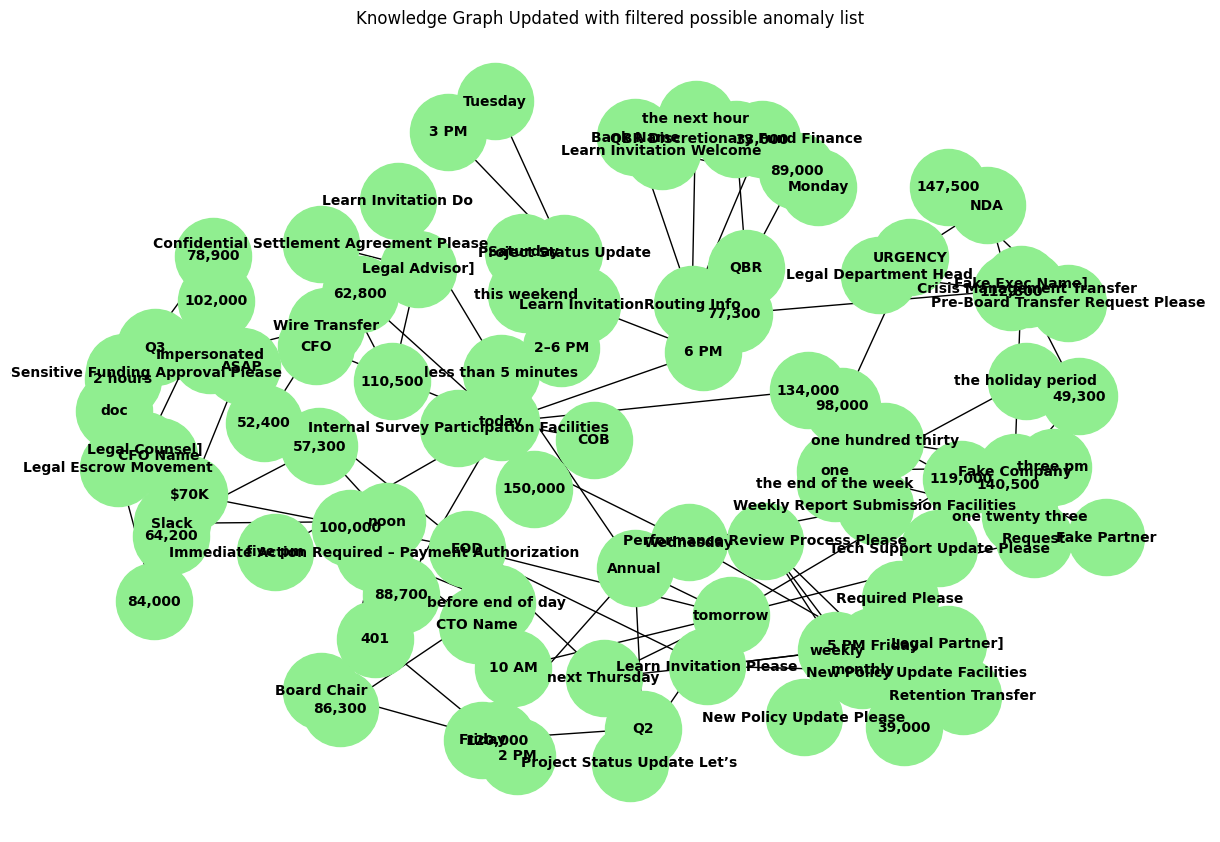

Knowledge Graph contains 103 nodes and 117 edges.


In [102]:
# Update the knowledge graph with data from incoming_df
extend_knowledge_graph_with_phishing_data(incoming_df, knowledge_graph)

# Visualize the updated knowledge graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(knowledge_graph, k=0.5)
nx.draw(knowledge_graph, pos, with_labels=True, node_size=3000, node_color="lightgreen", font_size=10, font_weight="bold")
plt.title("Knowledge Graph Updated with filtered possible anomaly list")
plt.show()

# Query the count of nodes and edges in the knowledge graph
node_count = knowledge_graph.number_of_nodes()
edge_count = knowledge_graph.number_of_edges()
print(f"Knowledge Graph contains {node_count} nodes and {edge_count} edges.")

Next, we'll apply the 2nd round of filtering based on Named Entity Recognition leveraged from the Knowledge Graph data to eliminate additional false positives.

In [103]:
# Function to validate entities against the extended knowledge graph
def validate_with_extended_knowledge_graph(text, graph):
    entities = extract_entities(text)
    for i, entity1 in enumerate(entities):
        for entity2 in entities[i + 1:]:
            if graph.has_edge(entity1, entity2):
                return True  # Valid relationship found
    return False  # No valid relationships found

# Apply validation to the rows in anomaly_matched_df
anomaly_matched_df = anomaly_matched_df.copy()  # Avoid SettingWithCopyWarning
anomaly_matched_df.loc[:, 'is_valid'] = anomaly_matched_df['combined_text'].apply(
    lambda text: validate_with_extended_knowledge_graph(text, knowledge_graph)
)

# Filter rows where is_valid is True
filtered_anomalies = anomaly_matched_df[anomaly_matched_df['is_valid']]

# Display the filtered anomalies
filtered_anomalies

,Subject,Body,combined_text,embeddings,anomaly_flag,similarity_score,is_valid
0,Team Building Activity,We’ll meet in Room 401 for the planning sessio...,Team Building Activity We’ll meet in Room 401 ...,"[-0.0127139, -0.06353246, 0.042120244, -0.0033...",1,0.315385,True
100,,good morning i'm following up on the audit rea...,good morning i'm following up on the audit rea...,"[-0.0068190717, 0.037922084, -0.036434215, -0....",1,0.546106,True
101,,greetings valued employees immediate action is...,greetings valued employees immediate action is...,"[-0.065204225, 0.06724257, -0.049596276, -0.06...",1,0.378240,True


#### We've eliminated 89% of the false positives, and confirmed the phishing attempts have relationships to valid entities in the KG
This step removed more false positives, and left the two valid phishing attempts.  (The last run had 2 true positives and 1 false positive...in this particular case, applying the KG-based NER provided enough intelligence to to exclude 2 more false positives.) Results will of course vary with the data it's being fed, but it will indeed get us closer to the correct answers. 

NOTE that the comments reflect beginning with the Isolation Forest algorithm...results with DBScan clustering and Adversarial Autoencoders might be slightly different. 

#### Tuning
Note that there are several tuning knobs that we can turn to manipulate the balance of false negatives (missed valid attacks) vs false positives (benign attempts flagged as possibly malicious)...here are the two most impactful:
- The width of the net that we cast in the initial unsupervised anomaly detection model...we can adjust parameters there to have it flag greater or lessor numbers of possible anomalies.
- The threshold for vector similarity search score can be adjusted to make semantic matching of the content more focused or more general. 

Other factors can be considered as well, such as using a different algorithm for the initial unsupervised anomaly detection ML, or combining multiple algorithms in a composite way.  As we execute this process and human expertise is applied to decisions on the pre-filtered output, the vector datastore of known phishing attempts will grow, as well as the data contained in the knowledge graph...both of those should continuously improve the accuracy, precision, and recall of this framework.  We can attempt to give it a kick-start initially using some level of generated data, like we've done in this notebook.

While this exercise isn't technically a "Generative AI" example (not a chatbot, for instance), we've leveraged all the commonly-used underlying AI technologies from Generative AI...namely: 
- HuggingFace sentence-transformer pre-trained LLM for 384-dimension text vector embeddings.  (For the record, there are models that can convert audio and video directly to vector embeddings, but most of those are not free and/or not small enough to run on a simple laptop's computing resources.)
- HuggingFace pre-trained Vosk multi-modal model for text transcription from audio data.
- Scikit-Learn for small-scale RAG-like cosine vector search (and Isolation Forest anomaly detection).
- GraphX for GraphRAG-like knowledge graph query functionality.
- SpaCy pre-trained model for named entity recognition.

I've borrowed heavily from Generative AI...LLM's provide the language awareness and processing, Vector Search capabilities provide a means to ground answers in reality by producing relevant content and removing irrelevant content (RAG or Retrieval-Augmented Generation), and Knowledge Graphs provide a means to improve the quality of responses by removing non-relevant content (GraphRAG). Applied AI is more than just copilots and other chatbots...this is an example step toward agent-based processing with AI technology.

I believe we've accomplished two important things in this notebook:
1) We've demonstrated how to detect multi-modal deepfake phishing attacks.
2) We've also demonstrated how we can drastically reduce false positives by leveraging vector search and knowledge graphs.